In [1]:
from dataget import data
import tfinterface as ti
import sonnet as snt
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cytoolz as cz

sess = tf.InteractiveSession()

In [2]:
dataset = data("mnist").get()

traning_set = dataset.complete_set

traning_set.df = traning_set.df.sample(frac=1)

In [3]:
class Discriminator(snt.AbstractModule):
    
    def _build(self, inputs):
        
        print("##########################")
        print("## Discriminator")
        print("##########################")
        
        net = inputs["image"]; print(net)
        training = inputs["mode"] == tf.estimator.ModeKeys.TRAIN
        
        net = ti.layers.conv2d_batch_norm(net, 64, [4, 4], strides = 2, activation = tf.nn.elu, 
                                          padding = "same", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_batch_norm(net, 128, [4, 4], strides = 2, activation = tf.nn.elu, 
                                          padding = "same", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_batch_norm(net, 256, [4, 4], strides = 1, activation = tf.nn.elu, 
                                          padding = "valid", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_batch_norm(net, 512, [4, 4], strides = 1, activation = tf.nn.elu, 
                                          padding = "valid", batch_norm = dict(training = training)); print(net)

        net = tf.squeeze(net, axis = [1, 2]); print(net)
 
        net = logits = tf.layers.dense(net, 1, activation = None); print(net)
    
#         net = tf.nn.sigmoid(net); print(net)
        
        return logits
    
    
class Generator(snt.AbstractModule):
    
    def _build(self, inputs):
        
        print("##########################")
        print("## Generator")
        print("##########################")
        
        training = inputs["mode"] == tf.estimator.ModeKeys.TRAIN
        net = inputs["embedding"]; print(net)
        
        net = ti.layers.conv2d_transpose_batch_norm(net, 512, [4, 4], strides = 1, activation = tf.nn.elu, 
                                                    padding = "valid", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_transpose_batch_norm(net, 256, [4, 4], strides = 1, activation = tf.nn.elu, 
                                                    padding = "valid", batch_norm = dict(training = training)); print(net)
        
        net = ti.layers.conv2d_transpose_batch_norm(net, 128, [4, 4], strides = 2, activation = tf.nn.elu, 
                                                    padding = "same", batch_norm = dict(training = training)); print(net)
        
        net = ti.layers.conv2d_transpose_batch_norm(net, 64, [4, 4], strides = 2, activation = tf.nn.elu, 
                                                    padding = "same", batch_norm = dict(training = training)); print(net)
        
        net = tf.layers.conv2d_transpose(net, 1, [4, 4], activation = tf.nn.sigmoid, padding = "same"); print(net)
        
#         net = (net + 1.0) / 2.0
        
        
        return net

In [4]:

inputs = dict(
    image = tf.layers.Input(shape=(28, 28, 1)),
    embedding = tf.layers.Input(shape=(1, 1, 100)),
    mode = tf.estimator.ModeKeys.TRAIN,
)

D = Discriminator(name = "discriminator")
G = Generator(name = "generator")

d = D(inputs)
print("")
g = G(inputs)

##########################
## Discriminator
##########################
Tensor("input_layer_1:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm/Elu:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm_1/Elu:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm_2/Elu:0", shape=(?, 4, 4, 256), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm_3/Elu:0", shape=(?, 1, 1, 512), dtype=float32)
Tensor("discriminator/Squeeze:0", shape=(?, 512), dtype=float32)
Tensor("discriminator/dense/BiasAdd:0", shape=(?, 1), dtype=float32)

##########################
## Generator
##########################
Tensor("input_layer_2:0", shape=(?, 1, 1, 100), dtype=float32)
Tensor("generator/Conv2dTransposeBatchNorm/Elu:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("generator/Conv2dTransposeBatchNorm_1/Elu:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator/Conv2dTransposeBatchNorm_2/Elu:0", shape=(?, 14, 14, 128), dtype=f

(28, 28)


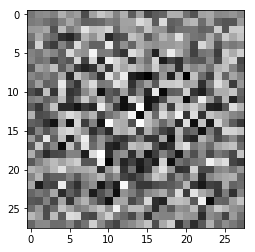

In [5]:
sample = np.random.uniform(size=(1, 1, 1, 100))
embedding = inputs["embedding"]

sess.run(tf.global_variables_initializer())

img = sess.run(g, feed_dict={embedding: sample})

img = np.squeeze(img * 255).astype(np.uint8)

print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

In [6]:
# class IteratorHook(tf.train.SessionRunHook):
        
#     def after_create_session(self, session, coord):
#         self.sess = session
    
#     def before_run(self, context):
#         self.sess.run(self.iterator.initializer)

# def get_train_input_fn():
#     hook = IteratorHook()
    
def train_input_fn(df, img_shape = [28, 28], embeddings_shape = [1, 1, 100], epochs = 10, batch_size = 64):

    def parse(filename):

        img = tf.read_file(filename)
        img = tf.image.decode_jpeg(img, channels = 1)
        img = tf.image.resize_images(img, img_shape)
        img = img / 255.0

        return img

    def embeddings():
        for i in range(len(df)):
            yield np.random.normal(size = [batch_size] + embeddings_shape)


    # ds_images
    ds_images = tf.data.Dataset.from_tensor_slices(df.filename.as_matrix())
    ds_images = ds_images.map(parse)
    ds_images = ds_images.shuffle(buffer_size = 500)
    ds_images = ds_images.batch(batch_size)

    #ds_embeddings
    ds_embeddings = tf.data.Dataset.from_generator(
        embeddings,
        output_types = tf.float32,
        output_shapes = tf.TensorShape([batch_size] + embeddings_shape)
    )

    # zip
    ds = tf.data.Dataset.zip((ds_images, ds_embeddings))

    # repeat
    ds = ds.repeat(epochs)

    # get iterator
    iterator = ds.make_one_shot_iterator()
    image, embedding = iterator.get_next()

    # set iterator
#     hook.iterator = iterator

    return dict(image = image, embedding = embedding), None
    
#     return train_input_fn, hook

{'image': <tf.Tensor 'IteratorGetNext:0' shape=(?, 28, 28, 1) dtype=float32>, 'embedding': <tf.Tensor 'IteratorGetNext:1' shape=(20, 1, 1, 100) dtype=float32>}
1.0


/home/cristian/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


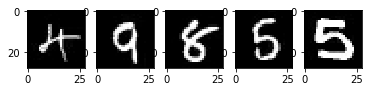

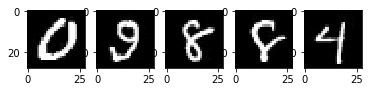

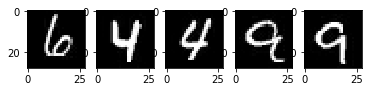

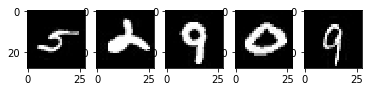

In [7]:
features, _ = train_input_fn(traning_set.df, batch_size=20)
image = features["image"]

print(features)

# with tf.train.MonitoredSession(hooks=[it_hook]) as sess:
    
images = sess.run(image)

print(np.max(images))

for images in cz.partition(5, images):

    fig, axes = plt.subplots(1, 5, subplot_kw=dict())

    for i, img in enumerate(images):


        img = np.squeeze(img * 255).astype(np.uint8)

        axes[i].imshow(img, cmap="gray")

    fig.show()

plt.show()

In [8]:
def model_fn(features, labels, mode, params):
    
    # predict features
    embedding = features["embedding"]
    
    D = Discriminator(name = "discriminator")
    G = Generator(name = "generator")
    
    # generator predictions
    fake_image = G(dict(
        embedding = embedding,
        mode = mode,
    ))
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode = mode,
            predictions = fake_image
        )
    
    
    # train features
    image = features["image"]
    
    # d_logits
    d_logits_real = D(dict(
        image = image,
        mode = mode,
    ))
    
    d_logits_fake = D(dict(
        image = fake_image,
        mode = mode,
    ))
    
    # labels
    is_real = tf.ones_like(d_logits_real, dtype=tf.float32)
    is_fake = tf.zeros_like(d_logits_fake, dtype=tf.float32)
    
    
    # d_loss_real
    d_loss_real = tf.losses.sigmoid_cross_entropy(is_real, d_logits_real)
    d_loss_real = tf.reduce_mean(d_loss_real)
    
    # d_loss_fake
    d_loss_fake = tf.losses.sigmoid_cross_entropy(is_fake, d_logits_fake)
    d_loss_fake = tf.reduce_mean(d_loss_fake)
    
    # d_loss
    d_loss = d_loss_real + d_loss_fake
    
    # g_loss
    g_loss = tf.losses.sigmoid_cross_entropy(is_real, d_logits_fake)
    
    # global loss
    loss = g_loss + d_loss
    
    # metrics
    tf.summary.scalar("activation_real", tf.reduce_mean(tf.nn.sigmoid(d_logits_real)))
    tf.summary.scalar("activation_fake", tf.reduce_mean(tf.nn.sigmoid(d_logits_fake)))
    
    tf.summary.scalar("discriminator_loss_real", d_loss_real)
    tf.summary.scalar("discriminator_loss_fake", d_loss_fake)
    tf.summary.scalar("generator_loss", g_loss)
    
    tf.summary.image("fake_imagas", fake_image)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode = mode,
            predictions = fake_image,
            loss = loss,
        )
    
    
    #updates
    d_update = tf.train.AdamOptimizer(params["learning_rate"], beta1=params["beta1"]).minimize(
        d_loss,
        var_list = D.get_variables(),
    )
    
    g_update = tf.train.AdamOptimizer(params["learning_rate"], beta1=params["beta1"]).minimize(
        g_loss,
        global_step = tf.train.get_global_step(),
        var_list = G.get_variables(),
    )
    
    # general update with batch_norm updates
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        update = tf.group(d_update, g_update)
    
    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = fake_image,
        loss = loss,
        train_op = update,
    )

In [9]:
estimator = tf.estimator.Estimator(
    model_fn = model_fn,
    model_dir = "models",
    params = dict(
        learning_rate = 0.0002,
        beta1 = 0.5,
    ),
    config = tf.estimator.RunConfig(save_checkpoints_steps = 50, save_summary_steps = 50)
)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f82fd247c90>, '_save_checkpoints_steps': 50, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'models', '_save_summary_steps': 50}


In [12]:
for i in range(100):
    try:
        estimator.train(
            input_fn = lambda: train_input_fn(traning_set.df, batch_size = 64, epochs = 20)
        )
    except StopIteration:
        break
    except tf.errors.OutOfRangeError:
        break
    except Exception:
        continue

##########################
## Generator
##########################
Tensor("IteratorGetNext:1", shape=(64, 1, 1, 100), dtype=float32, device=/device:CPU:0)
Tensor("generator/Conv2dTransposeBatchNorm/Elu:0", shape=(64, 4, 4, 512), dtype=float32)
Tensor("generator/Conv2dTransposeBatchNorm_1/Elu:0", shape=(64, 7, 7, 256), dtype=float32)
Tensor("generator/Conv2dTransposeBatchNorm_2/Elu:0", shape=(64, 14, 14, 128), dtype=float32)
Tensor("generator/Conv2dTransposeBatchNorm_3/Elu:0", shape=(64, 28, 28, 64), dtype=float32)
Tensor("generator/conv2d_transpose/Sigmoid:0", shape=(64, 28, 28, 1), dtype=float32)
##########################
## Discriminator
##########################
Tensor("IteratorGetNext:0", shape=(?, 28, 28, 1), dtype=float32, device=/device:CPU:0)
Tensor("discriminator/Conv2dBatchNorm/Elu:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm_1/Elu:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm_2/Elu:0", shape=(?, 4, 4, 256)

KeyboardInterrupt: 